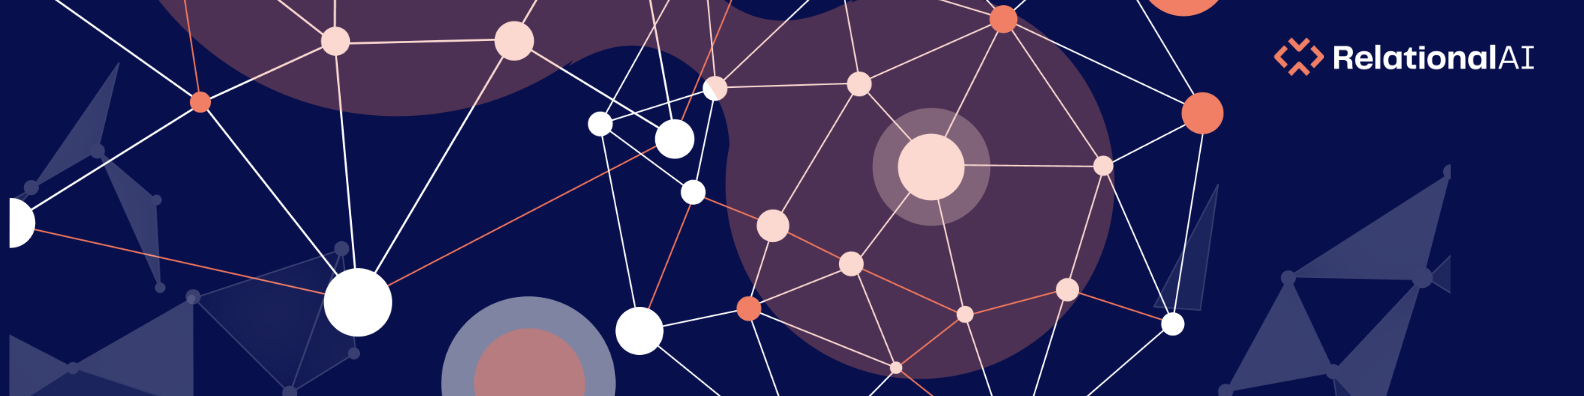

# Detecting sharing of user accounts

## Overview
This notebook provides an example of how RelationalAI can be used to detect whether a user account is shared between multiple people.

We will analyze a dataset that contains login information from users, together with details on both the device as well as the location from which they are logging into our fictitious application. Our fictitious company does not allow account sharing, our goal is therefore to first understand our users behavioral patterns, as well as to detect using different methods whether fraudulent behavior is being observed on some of these accounts.

To see examples that showcase more of RelationalAI's analytics capabilities, check out the other notebooks on the docs site.

## Let's get started!

If you haven't already done so, begin by installing the RelationalAI Native App in your Snowflake account. See [this page in the RelationalAI documentation](https://relational.ai/build/get-started/install-native-app) for instructions.

Next, [install RelationalAI's Python library into a local Python virtual environment](https://relational.ai/build/get-started#install-the-relationalai-python-package) and run `rai init` to connect your project to your Snowflake account.

This notebook is written with the assumption that you're running it from such a virtual environment. To do that, navigate in your terminal to your project's root directory and run the following commands:

```bash
source .venv/bin/activate
python -m pip install jupyter
jupyter lab
```

*Note: The first command assumes you put your virtual environment in `.venv` as specified in the instructions in the documentation linked above. If you put it somewhere else, adjust the path accordingly.*

Next, perform the necessary imports:

In [8]:
import relationalai as rai

from relationalai.std.graphs import Graph
from relationalai.std import aggregates as agg
from relationalai.std import alias, dates, Vars

from typing import Tuple
import pandas as pd

provider = rai.Provider()

The next two cells insert a table into Snowflake and create a data stream between that table and the RelationalAI app.

In [ ]:
provider.sql("""
begin
    create schema if not exists RAI_DEMO.FRAUD_DETECTION;

    create or replace table RAI_DEMO.FRAUD_DETECTION.USER_LOGS (
        USER_ID VARCHAR(16777216),
        TIMESTAMP TIMESTAMP_NTZ(9),
        PUBLIC_IP VARCHAR(16777216),
        CITY VARCHAR(16777216),
        DEVICE_TYPE VARCHAR(16777216),
        DEVICE_ID VARCHAR(16777216)
    );

    insert into RAI_DEMO.FRAUD_DETECTION.USER_LOGS (USER_ID,TIMESTAMP,PUBLIC_IP,CITY,DEVICE_TYPE,DEVICE_ID)
    values
        ('aunt_judy','2024-06-01T20:31:46Z','69.37.129.87','New York','tablet','judys_ipad'),
        ('aunt_judy','2024-06-03T14:37:59Z','69.37.129.87','New York','tablet','judys_ipad'),
        ('aunt_judy','2024-06-05T06:07:56Z','69.37.129.87','New York','tablet','judys_ipad'),
        ('aunt_judy','2024-06-08T06:41:19Z','69.37.129.87','New York','tablet','judys_ipad'),
        ('aunt_judy','2024-06-12T05:09:50Z','69.37.129.87','New York','tablet','judys_ipad'),
        ('aunt_judy','2024-06-14T12:02:11Z','69.37.129.87','New York','tablet','judys_ipad'),
        ('aunt_judy','2024-06-16T08:32:16Z','69.37.129.87','New York','tablet','judys_ipad'),
        ('travelling_salesman','2024-06-04T19:43:18Z','168.191.205.135','Los Angeles','desktop','ts imac'),
        ('travelling_salesman','2024-06-18T01:59:39Z','168.191.205.135','Los Angeles','desktop','ts imac'),
        ('travelling_salesman','2024-06-21T07:21:14Z','168.191.205.135','Los Angeles','desktop','ts imac'),
        ('travelling_salesman','2024-06-26T16:24:55Z','168.191.205.135','Los Angeles','desktop','ts imac'),
        ('travelling_salesman','2024-06-06T18:03:44Z','168.191.205.135','Los Angeles','desktop','ts imac'),
        ('travelling_salesman','2024-06-07T20:15:24Z','168.191.205.135','Los Angeles','desktop','ts imac'),
        ('travelling_salesman','2024-06-11T08:53:45Z','168.191.205.135','Los Angeles','desktop','ts imac'),
        ('travelling_salesman','2024-06-24T08:55:45Z','168.191.205.135','Los Angeles','desktop','ts imac'),
        ('travelling_salesman','2024-06-24T08:59:45Z','168.191.205.135','Los Angeles','tablet','ts ipad'),
        ('travelling_salesman','2024-06-21T09:31:45Z','151.239.231.47','San Francisco','tablet','ts ipad'),
        ('travelling_salesman','2024-06-01T07:07:10Z','146.157.47.128','Long Beach','tablet','ts ipad'),
        ('travelling_salesman','2024-06-14T10:21:57Z','67.148.79.79','San Diego','tablet','ts ipad'),
        ('travelling_salesman','2024-06-12T18:08:20Z','228.17.231.201','Fresno','tablet','ts ipad'),
        ('travelling_salesman','2024-06-17T13:59:40Z','33.25.1.249','Oakland','tablet','ts ipad'),
        ('travelling_salesman','2024-06-29T05:35:51Z','171.167.22.118','San Jose','tablet','ts ipad'),
        ('travelling_salesman','2024-06-05T14:35:24Z','202.17.239.114','Sacramento','tablet','ts ipad'),
        ('travelling_salesman','2024-06-08T11:29:11Z','233.189.189.48','Bakersfield','tablet','ts ipad'),
        ('catch_me_if_you_can','2024-06-14T14:38:29Z','38.45.1.249','Los Angeles','desktop','dannys laptop'),
        ('catch_me_if_you_can','2024-06-14T14:50:29Z','99.31.19.07','New York','desktop','franks macbook'),
        ('catch_me_if_you_can','2024-06-14T14:10:29Z','171.231.231.97','Atlanta','tablet','annys ipad'),
        ('catch_me_if_you_can','2024-06-14T14:20:29Z','100.33.3.205','Atlanta','desktop','marys computer'),
        ('catch_me_if_you_can','2024-06-20T09:00:15Z','38.45.1.249','Los Angeles','desktop','dannys laptop'),
        ('catch_me_if_you_can','2024-06-20T09:40:15Z','99.31.19.07','New York','desktop','franks macbook'),
        ('catch_me_if_you_can','2024-06-20T10:13:15Z','171.231.231.97','Atlanta','tablet','annys ipad'),
        ('catch_me_if_you_can','2024-06-20T09:21:15Z','100.33.3.205','Atlanta','desktop','marys computer'),
        ('catch_me_if_you_can','2024-06-20T10:32:15Z','38.45.1.249','Los Angeles','desktop','dannys laptop'),
        ('catch_me_if_you_can','2024-06-17T09:47:24Z','99.31.19.07','New York','desktop','franks macbook'),
        ('catch_me_if_you_can','2024-06-17T09:33:24Z','171.231.231.97','Atlanta','tablet','annys ipad'),
        ('catch_me_if_you_can','2024-06-17T09:26:24Z','100.33.3.205','Atlanta','desktop','marys computer'),
        ('catch_me_if_you_can','2024-06-17T11:22:24Z','38.45.1.249','Los Angeles','desktop','dannys laptop'),
        ('catch_me_if_you_can','2024-06-17T11:27:24Z','99.31.19.07','New York','desktop','franks macbook'),
        ('catch_me_if_you_can','2024-06-23T10:31:59Z','120.35.6.505','New York','desktop','tommys chromebook'),
        ('catch_me_if_you_can','2024-06-06T16:36:27Z','120.35.6.505','New York','desktop','tommys chromebook'),
        ('catch_me_if_you_can','2024-06-02T19:12:10Z','38.45.1.249','Los Angeles','desktop','dannys laptop'),
        ('catch_me_if_you_can','2024-06-17T05:54:51Z','99.31.19.07','New York','desktop','franks macbook');
end;
""")

### Define Model in RelationalAI
Let's define our model object. **Models** represent collections of objects. **Objects**, like Python objects, have **types** and **properties**, which we will define in a bit.

In [ ]:
model = rai.Model("login_sharing", ensure_change_tracking=True)

### Referencing Snowflake Data
Due to RelationalAI's tight integration with Snowflake, we can refer to data that we are streaming to our RelationalAI schema by simply referring to the source:\
**\<my_database>.\<my_schema>.<my_table\>**.

The data for this example consists of a single table called `USER_LOGS`. The table contains `events` pertaining to logins from users, such as their `user_id`, the `timestamp` together with information on the device that was used and the location from where the login took place. 

We therefore introduce a *type* called `Event` that represents these event objects in our model. We can query all the properties of objects of this type using `Event.known_properties()`.

In [10]:
Event = model.Type("Event", source="RAI_DEMO.FRAUD_DETECTION.USER_LOGS")

Event.known_properties()

['snowflake_id',
 'device_id',
 'public_ip',
 'user_id',
 'city',
 'device_type',
 'timestamp']

> **Note**. The `snowflake_id` property is the RAI internal identifier of a row in a Snowflake table and can be ignored.

## Weaving data into our model
Let's create a few more types for objects that are relevant for our use case. 
We then create two rules:
- one where we create instances for each of these types based on the occurrence of their identifier in our event table. At the same time, we set these objects as a property to each event instance, to create a relationship between them.
- in the second rule, we define additional properties for the `User` object.

In [11]:
User = model.Type("User")
Device = model.Type("Device")
IPAddress = model.Type("IPAddress")

with model.rule():
    e = Event()
    e.set(
        to_user = User.add(id=e.user_id),
        to_device = Device.add(id=e.device_id, type=e.device_type),
        to_ip_address = IPAddress.add(id=e.public_ip)
    )

with model.rule():
    u = User()
    e = Event(to_user = u)
    u.has_device.add(e.to_device)
    u.has_ip_address.add(e.to_ip_address)


## Visualizing the input data

Time to take a closer look at our input data! We'll do this by defining our nodes and edges. But before we do that, let's create a smaller helper function to style our graph, that we will be able to call upon also later in this notebook.

We assign different colors to nodes based on the type of the nodes. Notice how you can also configure other attributes such as the size of nodes, or their shape.

In [12]:
style = {
    "node": {
        "color": lambda n : 'firebrick' if n.get('focus') and n['type'] == 'User' else
           {'User': 'yellow', 'tablet': 'lightsteelblue', 'desktop': 'steelblue', 'IPAddress': 'grey'}[n['type']],
        "hover": lambda n: n['type'],
        "size": lambda n: {'User': 30, 'tablet': 15, 'desktop': 25, 'IPAddress': 15}[n['type']],
        "shape": lambda n: 'circle' if n['type'] == 'User' else 'rectangle',    },
    "edge": {
        "color":'grey',
    }
}

We then define a graph called `input_graph`, that we want to use to display the usage patterns from our users, in particular patterns such as: which devices they are using and from which IP addresses. Nodes in our graph therefore represent users, devices and IP addresses. We use the properties of users that we defined earlier via a rule as edges of the graph.

Note how we use the style that we defined earlier on the graph for visualization purposes. It also sets both the color and the size of each node of the `device` based on its device type (e.g. tablet/desktop)

In [13]:
input_graph = Graph(model)
Node, Edge = input_graph.Node, input_graph.Edge

Node.extend(User, label=User.id, type="User")
Node.extend(Device, label=Device.id, type=Device.type)
Node.extend(IPAddress, label=IPAddress.id, type="IPAddress")

Edge.extend(User.has_device)
Edge.extend(User.has_ip_address)

input_graph.visualize(three = False, node_label_size_factor = 1.5, edge_size_factor = 0.5, style = style).display(inline = True)

User `aunt_judy` only uses 1 device, and it seems that she's always using our application from the same IP address.

From a first look, the usage pattern from user `travelling_salesman` seems quite similar to the usage pattern of user `catch_me_if_you_can`. Let's see how this might change if we extend our data model a little bit.

## Identifying suspicious user activity
Let's create a rule that adds a property called `has_ip_address` to each device. This allows us to track from which IP addresses each device logged in.

In [14]:
with model.rule():
    d = Device()
    e = Event(to_device = d)
    d.has_ip_address.add(e.to_ip_address)

Let's see how our graph changes, if we use this new property as an edge between devices and IP addresses. We also add an edge between users and devices.

In [15]:
by_device_graph = Graph(model)
Node, Edge = by_device_graph.Node, by_device_graph.Edge

Node.extend(User, label=User.id, type="User")
Node.extend(Device, label=Device.id, type=Device.type)
Node.extend(IPAddress, label=IPAddress.id, type="IPAddress")

Edge.extend(User.has_device)
Edge.extend(Device.has_ip_address)

by_device_graph.visualize(three = False, node_label_size_factor = 1.5, edge_size_factor = 0.5, style = style).display(inline = True)

> **Note**. Can you spot how different the usage pattern between the users is? Does anything look suspicious to you? For instance, user `catch_me_if_you_can` seems to use different IP addresses for each of the devices. User `travelling_salesman` on the other hand only has 2 devices. Both devices have been used at one IP address, which most likely is the home (or work) address of that user. Additionally, this user is using one of their devices in many different locations. This could possibly be, because the user is using our application while on the road, e.g. visiting clients. 

We can run a few queries to help us understand even better what might be going on. For instance, let's query for each user on how many different devices they used our applications, as well as from how many different IP addresses.

In [16]:
with model.query() as select:
    u = User()
    c_d = agg.count(u.has_device, per = [u])
    c_ip = agg.count(u.has_ip_address, per = [u])
    res = select(alias(u.id,"user"), alias(c_d,"nr.devices"), alias(c_ip,"nr. ip addresses"))
res

> **Note**. User `catch_me_if_you_can` uses the largest number of devices, `travelling_salesman` on the other hand is logging in frequently from different IP addresses.

Let's run one more query: given that we know the type of each device, let's count how many devices, grouped by device type, each user has.


In [17]:
with model.query() as select:
    d = Device()
    u = User(has_device = d)
    c_d = agg.count(d, per = [u, d.type])
    res = select.distinct(alias(u.id,"user"), d.type, alias(c_d, "nr. devices"))
res

> **Note**. While it's possible to use our application from different devices, and it's also conceivable that someone has 2 devices over time of the same type (e.g. when you replace your device with a newer one), the behavior of user `catch_me_if_you_can` looks suspicious though with logins from 4 different desktops. Furthermore, this user also uses a different IP address on each of the devices.

What we therefore can do as a next step is to create a rule that tags each user that shows a suspicious behavior as a `SuspiciousUser`. Based on our observations, we could state that a user that uses our application on more than 2 different devices of the same type should be marked as suspicious.

In [18]:
SuspiciousUser = model.Type("SuspiciousUser")

with model.rule():
    d = Device()
    u = User(has_device = d)
    c_d = agg.count(d, per = [u, d.type])
    c_d > 2
    u.set(SuspiciousUser)

with model.query() as select:
    u = SuspiciousUser()
    res = select(u.id)
res

## Confirming Fraudulent Activity
Now that we have identified a user with suspicious activity, let's see if we can confirm that there is indeed some fraudulent behavior going on. 

One way to do this would be to check whether we can find overlapping events from the same user that took place in 2 different locations. Unfortunately, we only track user log ins and not how long a user was actually using our application. We can make an assumption though that there is most likely fraudulent activity in play if a user logs in within a certain time interval, let's say 20 minutes, from two different cities.

### Step 1 - Derive *next event*
Let's start by creating an ordered sequence of events, grouped by user, and derive the `has_next_event` property for each event of a suspicious user. We then query for each suspicious user the sorted even sequence, from which city the log in took place, as well as the timestamp and the city from the next event. If you look closely, you might spot some irregularities!

In [19]:
with model.rule():
    u = SuspiciousUser()
    e = Event(to_user = u)
    r = agg.rank_asc(e.timestamp, u)
    e.set(rank = r)

with model.rule():
    u = SuspiciousUser()
    e1 = Event(to_user = u)
    e2 = Event(to_user = u)
    e1.rank == e2.rank - 1
    e1.set(has_next_event = e2)

with model.query() as select:
    u = SuspiciousUser()
    e = Event(to_user = u)
    res = select(u.id, e.rank, e.timestamp, e.city, alias(e.has_next_event.timestamp,"timestamp next event"), alias(e.has_next_event.city,"city next event"))
res

### Step 2 - Derive Fraudulent Users
It looks indeed that this *user has committed a fraudulent activity* and there is some amount of account sharing going on. So let's write a rule that tags each user with fraudulent behavior as a `FraudulentUser`.

We do this in case there exists at least one event where the next event took place within a configurable interval that we set in `suspicious_interval_in_milliseconds`, where the city property of the events do not match.

In [20]:
# suspicious time interval
suspicious_interval_in_milliseconds = 1200000 # = 20minutes
FraudulentUser = model.Type("FraudulentUser")

with model.rule():
    u = SuspiciousUser()
    with model.found():
        e = Event(to_user = u)
        e.has_next_event.timestamp - e.timestamp == dates.milliseconds(diff_ms := Vars(1))
        diff_ms <= suspicious_interval_in_milliseconds
        e.city != e.has_next_event.city
    u.set(FraudulentUser)

with model.query() as select:
    u = FraudulentUser()
    res = select(u.id)
res

## What to do next?
Now that we have identified fraudulent users in our dataset, we want to provide a way for users of this little fraud detection application to get the results of our analysis directly from Snowflake. 

In order to do that, we create a stored procedure, which returns all of the instances of `FraudulentUser`. Alternatively, it would have been possible to write the results back directly into a Snowflake table.

In [21]:
@model.export("rai_demo.fraud_detection")
def fraudulent_logins() -> Tuple[str]:
    u = FraudulentUser()
    return u.id


Let's execute the procedure to take a look at the results.

In [22]:
pd.DataFrame(model.resources._exec(f"call rai_demo.fraud_detection.fraudulent_logins();"), columns = ["id"])

id
0  catch_me_if_you_can